# Support and resistance

In [ ]:
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import numpy as np

# List of tickers
list_ticker = [
    "AI.PA",
    "AIR.PA",
    "STMPA.PA"
]

# Constants
INVESTMENT_AMOUNT = 100000  # Amount invested each time
RISK_FREE_RATE = 0.01  # Assumed risk-free rate for Sharpe ratio calculation

# Function to calculate Pivot Point, Resistance, and Support
def calculate_pivot_resistance_support(data):
    data['Pivot Point'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['Resistance'] = 3 * data['Pivot Point'] - data['Low']
    data['Support'] = 3 * data['Pivot Point'] - data['High']
    return data

# Function to generate trading signals based on Support and Resistance levels
def support_resistance_signals(data):
    long_signals = pd.Series(False, index=data.index)
    short_signals = pd.Series(False, index=data.index)

    for date in data.index:
        current_price = data.at[date, 'Close']
        if current_price > data.at[date, 'Pivot Point']:
            long_signals.at[date] = True
        elif current_price <= data.at[date, 'Support']:
            short_signals.at[date] = True

    return long_signals, short_signals, data

# Function to calculate performance metrics
def calculate_performance_metrics(ticker, returns, risk_free_rate):
    if len(returns) > 1:
        annualized_volatility = np.std(returns) * np.sqrt(252)
        sharpe_ratio = (np.mean(returns) - risk_free_rate) / (np.std(returns) * np.sqrt(252)) if np.std(returns) != 0 else 0.0
    else:
        annualized_volatility = 0.0
        sharpe_ratio = 0.0
    return annualized_volatility, sharpe_ratio

# Function to execute Support and Resistance strategy
def execution_support_resistance_strategy(ticker, start_date, end_date):
    # Download historical data
    data = yf.download(ticker, start=start_date, end=end_date)
    data = calculate_pivot_resistance_support(data)

    long_signals, short_signals, data = support_resistance_signals(data)

    in_position = False
    entry_price = 0
    total_return = 0
    entry_date = []
    exit_date = []
    position_sizes = []
    daily_returns = []

    # Adjust end_date to the closest available date in data if it's not present
    end_date = pd.to_datetime(end_date)
    if end_date not in data.index:
        end_date = data.index[data.index < end_date][-1]

    for date in data.index:
        if not in_position and long_signals[date]:
            entry_price = data.at[date, 'Close']
            position_size = INVESTMENT_AMOUNT / entry_price
            position_sizes.append(position_size)
            entry_date.append(date)
            in_position = True
        elif in_position and (short_signals[date] or date == end_date):
            exit_price = data.at[date, 'Close']
            total_return += (exit_price - entry_price) * position_sizes[-1]
            exit_date.append(date)
            daily_returns.append((exit_price - entry_price) / entry_price)
            in_position = False

    total_return_percent = (total_return / INVESTMENT_AMOUNT) * 100 if position_sizes else 0

    # Calculate performance metrics
    daily_returns = pd.Series(daily_returns)
    annualized_volatility, sharpe_ratio = calculate_performance_metrics(ticker, daily_returns, RISK_FREE_RATE)

    return total_return_percent, entry_date, exit_date, annualized_volatility, sharpe_ratio, data

# Function to execute the strategy for a list of tickers
def support_resistance_strategy_trading_final(tickers, start_date, end_date):
    results = []

    for ticker in tickers:
        total_return, entry_date, exit_date, annualized_volatility, sharpe_ratio, data = execution_support_resistance_strategy(ticker, start_date, end_date)
        print(f"Total Return Rate for {ticker}: {total_return:.2f} %")
        print(f"Entry Dates for {ticker}: {entry_date}")
        print(f"Exit Dates for {ticker}: {exit_date}")
        print(f"Annualized Volatility for {ticker}: {annualized_volatility:.2f}")
        print(f"Sharpe Ratio for {ticker}: {sharpe_ratio:.2f}")

        # Collect results for the table
        results.append({
            'Ticker': ticker,
            'Total Return (%)': total_return,
            'Annualized Volatility': annualized_volatility,
            'Sharpe Ratio': sharpe_ratio
        })

        # Filter data for long and short signals for plotting
        long_signals, short_signals, _ = support_resistance_signals(data)
        long_data = data[long_signals]
        short_data = data[short_signals]

        # Dynamic plot using Plotly
        fig = go.Figure()

        # Plot the price
        fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name=f'{ticker} Price'))

        # Plot support and resistance lines
        fig.add_trace(go.Scatter(x=data.index, y=data['Support'], mode='lines', name='Support', line=dict(color='blue', dash='dash')))
        fig.add_trace(go.Scatter(x=data.index, y=data['Resistance'], mode='lines', name='Resistance', line=dict(color='red', dash='dash')))

        # Plot long and short signals
        fig.add_trace(go.Scatter(x=long_data.index, y=long_data['Close'], mode='markers', name='Long Signal', marker=dict(color='green', size=10, symbol='triangle-up')))
        fig.add_trace(go.Scatter(x=short_data.index, y=short_data['Close'], mode='markers', name='Short Signal', marker=dict(color='red', size=10, symbol='triangle-down')))

        # Update layout
        fig.update_layout(title=f'{ticker} Support and Resistance Trading Signals', xaxis_title='Date', yaxis_title='Price')
        fig.show()

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results)
    print("\nPerformance Metrics:")
    print(results_df)

# Run the strategy

support_resistance_strategy_trading_final(list_ticker, '2023-01-01', '2024-06-01')


[*********************100%%**********************]  1 of 1 completed


Total Return Rate for AI.PA: 19.03 %
Entry Dates for AI.PA: [Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-04 00:00:00'), Timestamp('2023-01-11 00:00:00'), Timestamp('2023-01-16 00:00:00'), Timestamp('2023-01-24 00:00:00'), Timestamp('2023-02-02 00:00:00'), Timestamp('2023-02-07 00:00:00'), Timestamp('2023-02-13 00:00:00'), Timestamp('2023-02-15 00:00:00'), Timestamp('2023-02-27 00:00:00'), Timestamp('2023-03-02 00:00:00'), Timestamp('2023-03-07 00:00:00'), Timestamp('2023-03-14 00:00:00'), Timestamp('2023-03-16 00:00:00'), Timestamp('2023-03-20 00:00:00'), Timestamp('2023-03-22 00:00:00'), Timestamp('2023-03-29 00:00:00'), Timestamp('2023-04-05 00:00:00'), Timestamp('2023-04-17 00:00:00'), Timestamp('2023-04-27 00:00:00'), Timestamp('2023-05-03 00:00:00'), Timestamp('2023-05-09 00:00:00'), Timestamp('2023-05-11 00:00:00'), Timestamp('2023-05-18 00:00:00'), Timestamp('2023-05-24 00:00:00'), Timestamp('2023-05-26 00:00:00'), Timestamp('2023-06-01 00:00:00'), Timestamp('2023-06-12

[*********************100%%**********************]  1 of 1 completed


Total Return Rate for AIR.PA: 18.43 %
Entry Dates for AIR.PA: [Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-04 00:00:00'), Timestamp('2023-01-06 00:00:00'), Timestamp('2023-01-11 00:00:00'), Timestamp('2023-01-17 00:00:00'), Timestamp('2023-01-20 00:00:00'), Timestamp('2023-01-26 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-08 00:00:00'), Timestamp('2023-02-10 00:00:00'), Timestamp('2023-02-21 00:00:00'), Timestamp('2023-02-27 00:00:00'), Timestamp('2023-03-02 00:00:00'), Timestamp('2023-03-07 00:00:00'), Timestamp('2023-03-09 00:00:00'), Timestamp('2023-03-14 00:00:00'), Timestamp('2023-03-16 00:00:00'), Timestamp('2023-03-20 00:00:00'), Timestamp('2023-03-27 00:00:00'), Timestamp('2023-03-29 00:00:00'), Timestamp('2023-04-06 00:00:00'), Timestamp('2023-04-14 00:00:00'), Timestamp('2023-04-24 00:00:00'), Timestamp('2023-04-27 00:00:00'), Timestamp('2023-05-05 00:00:00'), Timestamp('2023-05-09 00:00:00'), Timestamp('2023-05-12 00:00:00'), Timestamp('2023-05-

[*********************100%%**********************]  1 of 1 completed

Total Return Rate for STMPA.PA: -15.47 %
Entry Dates for STMPA.PA: [Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-04 00:00:00'), Timestamp('2023-01-13 00:00:00'), Timestamp('2023-01-20 00:00:00'), Timestamp('2023-01-25 00:00:00'), Timestamp('2023-02-03 00:00:00'), Timestamp('2023-02-09 00:00:00'), Timestamp('2023-02-13 00:00:00'), Timestamp('2023-02-15 00:00:00'), Timestamp('2023-02-21 00:00:00'), Timestamp('2023-02-27 00:00:00'), Timestamp('2023-03-02 00:00:00'), Timestamp('2023-03-08 00:00:00'), Timestamp('2023-03-14 00:00:00'), Timestamp('2023-03-16 00:00:00'), Timestamp('2023-03-20 00:00:00'), Timestamp('2023-03-22 00:00:00'), Timestamp('2023-03-29 00:00:00'), Timestamp('2023-04-13 00:00:00'), Timestamp('2023-04-21 00:00:00'), Timestamp('2023-04-26 00:00:00'), Timestamp('2023-05-05 00:00:00'), Timestamp('2023-05-10 00:00:00'), Timestamp('2023-05-12 00:00:00'), Timestamp('2023-05-16 00:00:00'), Timestamp('2023-05-22 00:00:00'), Timestamp('2023-05-26 00:00:00'), Timestamp('202


Performance Metrics:
     Ticker  Total Return (%)  Annualized Volatility  Sharpe Ratio
0     AI.PA         19.032069               0.289157     -0.026653
1    AIR.PA         18.430415               0.308601     -0.026051
2  STMPA.PA        -15.472755               0.461650     -0.025117


# Channel

In [ ]:
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

# List of tickers
list_ticker = [
    "AI.PA",
    "AIR.PA",
    "STMPA.PA"
]

# Constants
LOOKBACK_PERIOD = 20  # Look-back period for predictor variables
PREDICTION_PERIOD = 10  # Prediction period (days ahead)
K_NEIGHBORS = 5  # Number of nearest neighbors
INVESTMENT_AMOUNT = 100000  # Amount invested each time
RISK_FREE_RATE = 0.01  # Assumed risk-free rate for Sharpe ratio calculation
THRESHOLD_LONG = 0.02  # Threshold for establishing a long position
THRESHOLD_SHORT = -0.02  # Threshold for establishing a short position

# Function to load and prepare data
def load_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Return'] = data['Close'].pct_change(PREDICTION_PERIOD)
    data.dropna(inplace=True)
    return data

# Function to create features (predictor variables)
def create_features(data, lookback_period):
    data['MA_Volume'] = data['Volume'].rolling(window=lookback_period).mean()
    data['MA_Price'] = data['Close'].rolling(window=lookback_period).mean()
    data.dropna(inplace=True)

    # Normalize features
    scaler = MinMaxScaler()
    features = data[['MA_Volume', 'MA_Price']]
    features_scaled = scaler.fit_transform(features)
    return features_scaled, data['Return']

# Function to predict future returns using KNN
def knn_predict(features, returns, k_neighbors):
    knn = NearestNeighbors(n_neighbors=k_neighbors, metric='euclidean')
    knn.fit(features)

    predicted_returns = []
    for i in range(len(features)):
        if i < k_neighbors:
            predicted_returns.append(np.nan)  # Not enough neighbors to predict
        else:
            distances, indices = knn.kneighbors([features[i]], n_neighbors=k_neighbors)
            avg_return = returns.iloc[indices.flatten()].mean()
            predicted_returns.append(avg_return)

    return np.array(predicted_returns)

# Function to generate trading signals based on predicted returns
def generate_signals(predicted_returns, threshold_long, threshold_short):
    signals = pd.Series(0, index=range(len(predicted_returns)))
    signals[predicted_returns > threshold_long] = 1
    signals[predicted_returns < threshold_short] = -1
    return signals

# Function to calculate performance metrics
def calculate_performance_metrics(ticker, returns, risk_free_rate):
    if len(returns) > 1:
        annualized_volatility = np.std(returns) * np.sqrt(252)
        sharpe_ratio = (np.mean(returns) - risk_free_rate) / (np.std(returns) * np.sqrt(252)) if np.std(returns) != 0 else 0.0
    else:
        annualized_volatility = 0.0
        sharpe_ratio = 0.0
    return annualized_volatility, sharpe_ratio

# Function to execute the KNN Strategy
def execution_knn_strategy(ticker, start_date, end_date, lookback_period, k_neighbors):
    # Load and prepare data
    data = load_data(ticker, start_date=start_date, end_date=end_date)
    features, returns = create_features(data, lookback_period)
    predicted_returns = knn_predict(features, returns, k_neighbors)

    signals = generate_signals(predicted_returns, THRESHOLD_LONG, THRESHOLD_SHORT)
    data['Signal'] = signals
    data['Predicted Return'] = predicted_returns

    # Calculate daily returns based on the strategy
    data['Strategy Return'] = data['Signal'].shift(1) * data['Return']
    data.dropna(inplace=True)

    total_return_percent = data['Strategy Return'].sum() * 100
    annualized_volatility, sharpe_ratio = calculate_performance_metrics(ticker, data['Strategy Return'], RISK_FREE_RATE)

    return total_return_percent, data.index, data['Strategy Return'], annualized_volatility, sharpe_ratio, data

# Function to execute the strategy for a list of tickers
def knn_strategy_trading_final(tickers, start_date, end_date, lookback_period, k_neighbors):
    results = []

    for ticker in tickers:
        total_return, dates, strategy_returns, annualized_volatility, sharpe_ratio, data = execution_knn_strategy(ticker, start_date, end_date, lookback_period, k_neighbors)
        print(f"Total Return Rate for {ticker}: {total_return:.2f} %")
        print(f"Annualized Volatility for {ticker}: {annualized_volatility:.2f}")
        print(f"Sharpe Ratio for {ticker}: {sharpe_ratio:.2f}")

        # Collect results for the table
        results.append({
            'Ticker': ticker,
            'Total Return (%)': total_return,
            'Annualized Volatility': annualized_volatility,
            'Sharpe Ratio': sharpe_ratio
        })

        # Filter data for long and short signals for plotting
        long_signals = data[data['Signal'] == 1]
        short_signals = data[data['Signal'] == -1]

        # Dynamic plot using Plotly
        fig = go.Figure()

        # Plot the price
        fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name=f'{ticker} Price'))

        # Plot long and short signals
        fig.add_trace(go.Scatter(x=long_signals.index, y=long_signals['Close'], mode='markers', name='Long Signal', marker=dict(color='green', size=10, symbol='triangle-up')))
        fig.add_trace(go.Scatter(x=short_signals.index, y=short_signals['Close'], mode='markers', name='Short Signal', marker=dict(color='red', size=10, symbol='triangle-down')))

        # Update layout
        fig.update_layout(title=f'{ticker} KNN Strategy Trading Signals', xaxis_title='Date', yaxis_title='Price')
        fig.show()

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results)
    print("\nPerformance Metrics:")
    print(results_df)

# Run the strategy
knn_strategy_trading_final(list_ticker, '2023-01-01', '2024-06-01', LOOKBACK_PERIOD, K_NEIGHBORS)


[*********************100%%**********************]  1 of 1 completed


Total Return Rate for AI.PA: 0.00 %
Annualized Volatility for AI.PA: 0.00
Sharpe Ratio for AI.PA: 0.00


[*********************100%%**********************]  1 of 1 completed


Total Return Rate for AIR.PA: 0.00 %
Annualized Volatility for AIR.PA: 0.00
Sharpe Ratio for AIR.PA: 0.00


[*********************100%%**********************]  1 of 1 completed


Total Return Rate for STMPA.PA: 0.00 %
Annualized Volatility for STMPA.PA: 0.00
Sharpe Ratio for STMPA.PA: 0.00



Performance Metrics:
     Ticker  Total Return (%)  Annualized Volatility  Sharpe Ratio
0     AI.PA               0.0                    0.0           0.0
1    AIR.PA               0.0                    0.0           0.0
2  STMPA.PA               0.0                    0.0           0.0


# Statistical arbitrage – optimization

[*********************100%%**********************]  7 of 7 completed
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


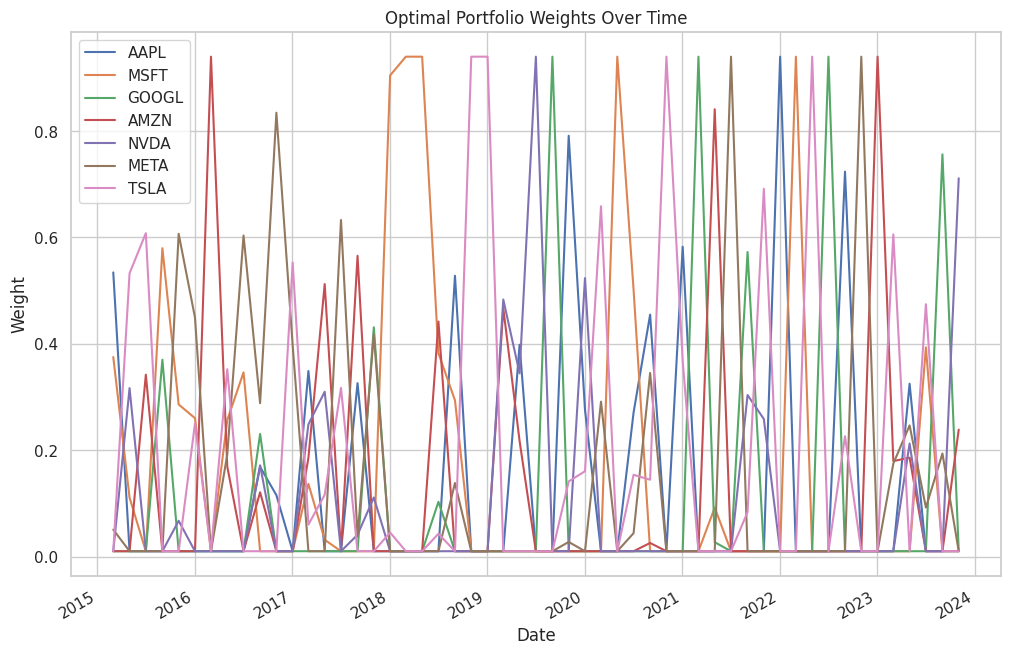

In [99]:
import numpy as np
import yfinance as yf
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime

list_ticker = [
    "AAPL",
    "MSFT",
    "GOOGL",
    "AMZN",
    "NVDA",
    "META",
    "TSLA"
]


# Define the period for historical data
start_date = "2015-01-01"  # Adjust start date as needed
end_date = "2024-01-01"    # Adjust end date as needed

# Load Data
def load_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    return data

# Rolling Window Optimization
def rolling_window_optimization(data, window_size, rebalance_frequency, tickers):
    results = []
    dates = []

    start_date = data.index[0]
    end_date = data.index[-1]
    current_date = start_date

    while current_date <= end_date:
        end_window_date = current_date + pd.DateOffset(months=window_size)
        if end_window_date > end_date:
            break

        window_data = data[(data.index >= current_date) & (data.index < end_window_date)]

        # Calculate daily returns
        returns = window_data.pct_change().dropna()

        if returns.shape[0] == 0:
            current_date += pd.DateOffset(months=rebalance_frequency)
            continue

        # Calculate mean returns and covariance matrix
        E = returns.mean()
        C = returns.cov()

        # Initial guess for weights
        w0 = np.ones(len(E)) / len(E) + np.random.normal(0, 0.01, len(E))

        # Constraints: sum of weights = 1
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

        # Bounds: Ensure a minimum weight of 0.01 for each stock and maximum of 1
        bounds = [(0.01, 1)] * len(E)

        # Sharpe Ratio Objective Function
        def sharpe_ratio(w, E, C):
            P = np.dot(w, E)  # Portfolio return
            V = np.sqrt(np.dot(w.T, np.dot(C, w)))  # Portfolio volatility
            return -P / V  # Minimize negative Sharpe ratio

        # Optimization
        result = minimize(sharpe_ratio, w0, args=(E, C), constraints=constraints, bounds=bounds)
        w_opt = result.x

        # Store results
        results.append(w_opt)
        dates.append(end_window_date)

        # Move to next window
        current_date += pd.DateOffset(months=rebalance_frequency)

    return pd.DataFrame(results, index=dates, columns=tickers)

# Load historical data
data = load_data(list_ticker, start_date, end_date)

# Set rolling window size and rebalance frequency (in months)
window_size = 2
rebalance_frequency = 2

# Run rolling window optimization
optimal_weights_df = rolling_window_optimization(data, window_size, rebalance_frequency, list_ticker)

# Print the optimal weights for the first few periods
# print(optimal_weights_df.head())

# Plot the results
optimal_weights_df.plot(figsize=(12, 8))
plt.title('Optimal Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


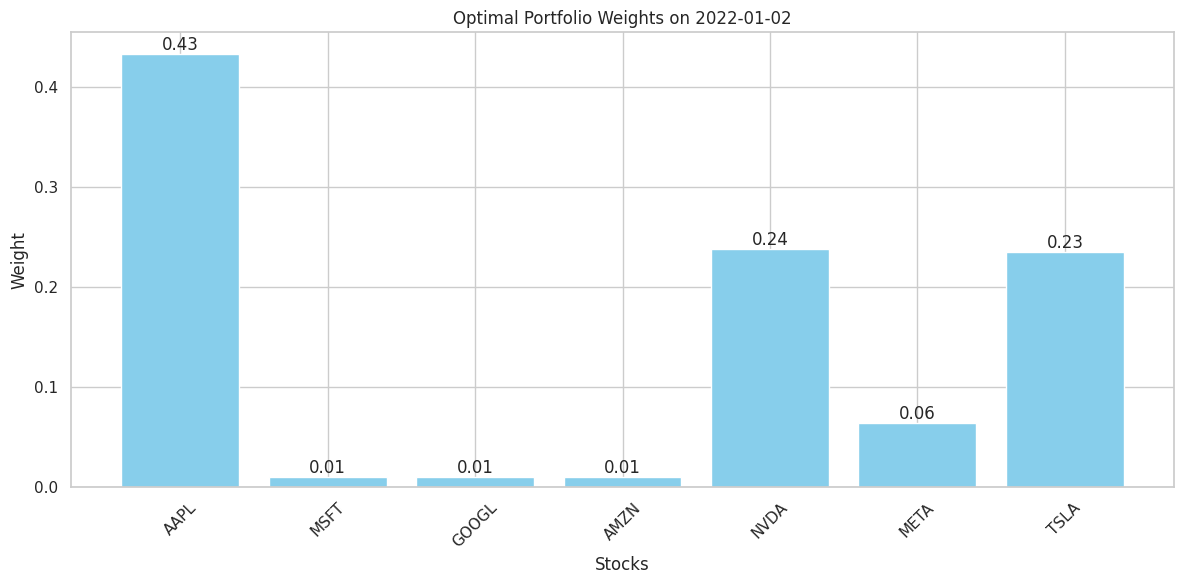

In [36]:
# Specify the date for which you want to plot the weights
specific_date = pd.Timestamp('2022-01-02')  # Example date, adjust as needed

# Check if the specific date is in the DataFrame
if specific_date in optimal_weights_df.index:
    weights = optimal_weights_df.loc[specific_date]
else:
    print("Date not found in the DataFrame.")
    weights = None

# Plotting
if weights is not None:
    plt.figure(figsize=(12, 6))
    bars = plt.bar(weights.index, weights.values, color='skyblue')

    # Add labels and title
    plt.xlabel('Stocks')
    plt.ylabel('Weight')
    plt.title(f'Optimal Portfolio Weights on {specific_date.strftime("%Y-%m-%d")}')
    plt.xticks(rotation=45)

    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', va='bottom', ha='center')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Alpha Combos

[*********************100%%**********************]  7 of 7 completed


Optimal Portfolio Weights:
AAPL     0.132729
MSFT     0.042415
GOOGL    0.628137
AMZN    -0.071653
NVDA     0.084657
META     0.040409
dtype: float64


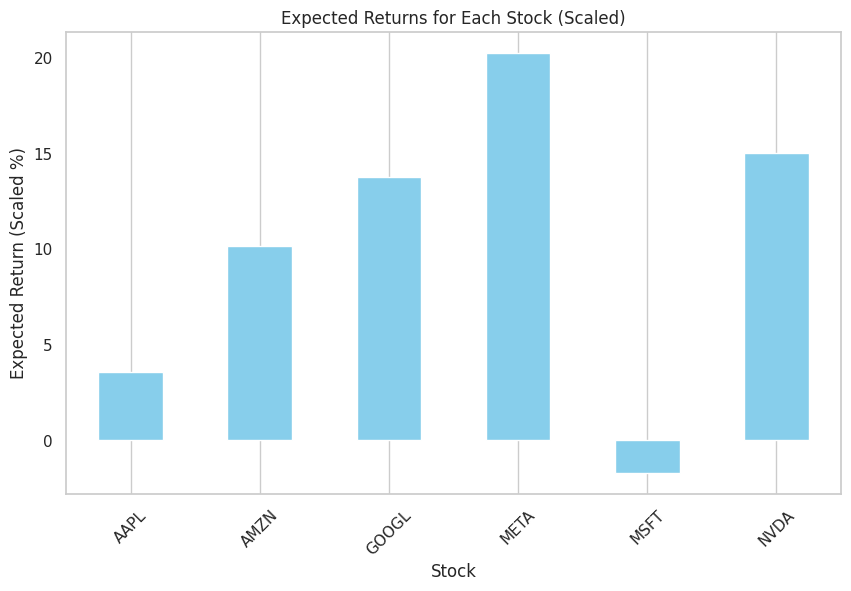

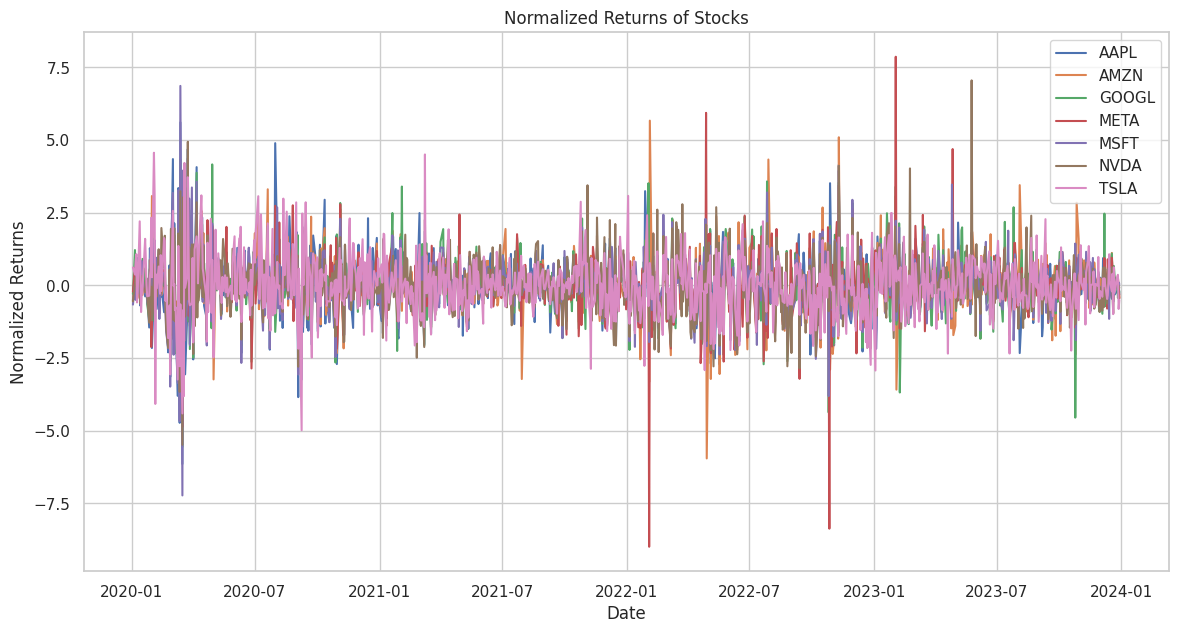

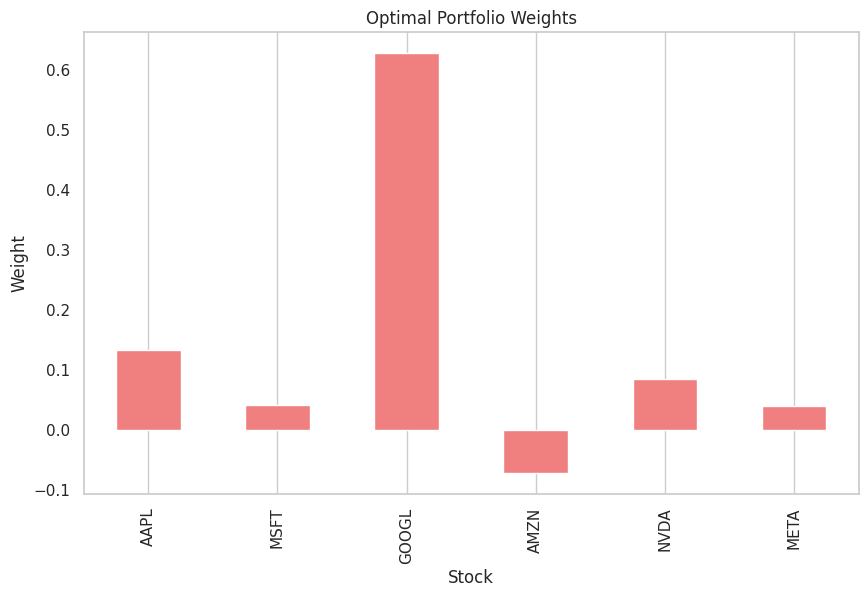

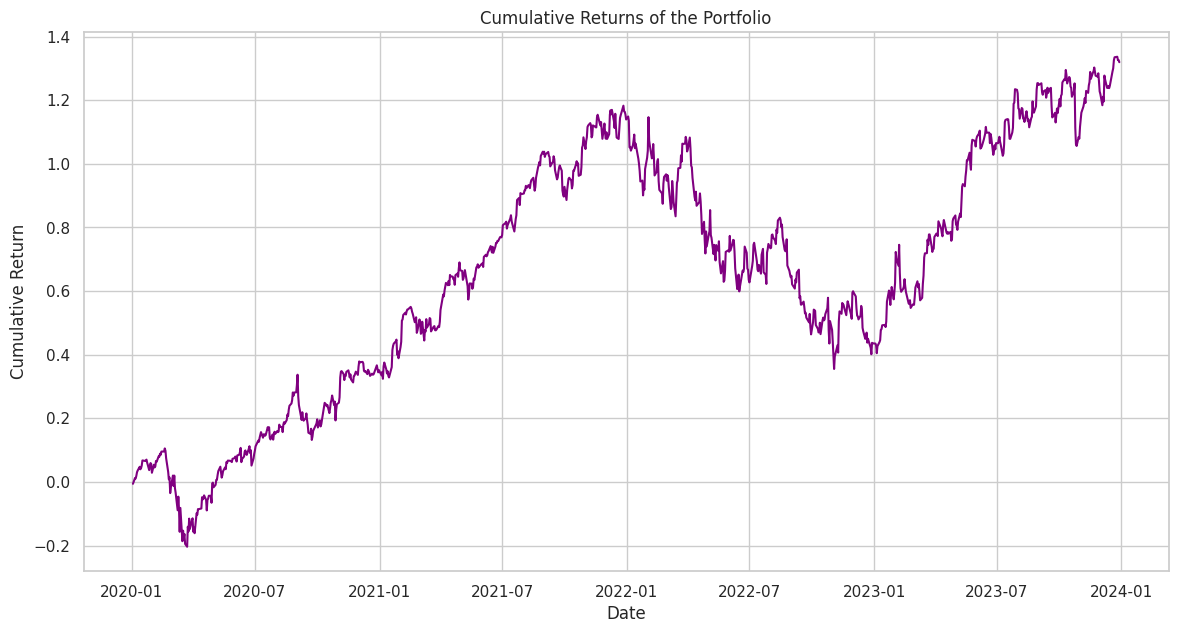

In [97]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load historical data
def load_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    return data

# Calculate expected alpha returns
def calculate_expected_returns(returns, window=20):
    return returns.rolling(window=window).mean().iloc[window-1:]

# Alpha combos strategy implementation
def alpha_combos_strategy(tickers, start_date, end_date, window=20):
    # Load historical data
    data = load_data(tickers, start_date, end_date)

    # Calculate daily returns
    returns = data.pct_change().dropna()

    # Calculate expected alpha returns
    expected_returns = calculate_expected_returns(returns, window=window)

    # Only use the most recent data for expected returns
    expected_returns = expected_returns.iloc[-1]

    # Preprocess alphas
    demeaned_returns = returns - returns.mean()
    variances = returns.var()
    normalized_returns = demeaned_returns / np.sqrt(variances)

    # Ensure dimensions match
    M = min(window, normalized_returns.shape[1])
    normalized_returns = normalized_returns.iloc[:, :M]

    # Expected returns for the selected columns
    expected_returns = expected_returns.iloc[:M]

    # Cross-sectionally demean
    cross_sectional_mean = normalized_returns.mean()
    demeaned_normalized_returns = normalized_returns - cross_sectional_mean

    # Keep only the first M - 1 columns
    M_minus_1 = M - 1
    if M_minus_1 > 0:
        demeaned_normalized_returns = demeaned_normalized_returns.iloc[:, :M_minus_1]
        expected_returns = expected_returns.iloc[:M_minus_1]
        variances = variances.iloc[:M]

    # Normalize expected alpha returns
    scaled_expected_returns = expected_returns / np.sqrt(variances.iloc[:M_minus_1])

    # Ensure dimensions are correct for regression
    X = demeaned_normalized_returns.values
    y = np.tile(scaled_expected_returns.values, (X.shape[0], 1))

    # Ensure dimensions are consistent
    if X.shape[0] != y.shape[0]:
        raise ValueError("Mismatch in dimensions between features and target variable.")

    # Regression to calculate residuals
    reg = LinearRegression()
    reg.fit(X, y)
    residuals = y - reg.predict(X)

    # Calculate weights
    weights = residuals.mean(axis=0) / np.sqrt(variances.iloc[:M_minus_1])
    normalization_factor = np.sum(np.abs(weights))
    weights = (weights / normalization_factor)

    # Create portfolio
    portfolio = pd.Series(weights, index=tickers[:M_minus_1])

    alphas = pd.DataFrame(residuals, index=returns.index, columns=[f'Alpha {i+1}' for i in range(residuals.shape[1])])

    return data, returns, expected_returns, normalized_returns, alphas,pd.DataFrame(residuals, index=returns.index), portfolio

def plot_expected_returns(expected_returns):
    # Convert expected returns to a scaled percentage (multiply by 400)
    expected_returns_scaled = expected_returns * 5000

    # Plot
    plt.figure(figsize=(10, 6))
    expected_returns_scaled.plot(kind='bar', color='skyblue')
    plt.title('Expected Returns for Each Stock (Scaled)')
    plt.xlabel('Stock')
    plt.ylabel('Expected Return (Scaled %)')
    plt.grid(axis='y')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

def plot_normalized_returns(normalized_returns):
    plt.figure(figsize=(14, 7))
    for ticker in normalized_returns.columns:
        plt.plot(normalized_returns.index, normalized_returns[ticker], label=ticker)
    plt.title('Normalized Returns of Stocks')
    plt.xlabel('Date')
    plt.ylabel('Normalized Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_portfolio_weights(portfolio):
    plt.figure(figsize=(10, 6))
    portfolio.plot(kind='bar', color='lightcoral')
    plt.title('Optimal Portfolio Weights')
    plt.xlabel('Stock')
    plt.ylabel('Weight')
    plt.grid(axis='y')
    plt.show()

def plot_cumulative_returns(returns, portfolio_weights):
    portfolio_returns = (returns * portfolio_weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1

    plt.figure(figsize=(14, 7))
    plt.plot(cumulative_returns.index, cumulative_returns, label='Portfolio Cumulative Returns', color='purple')
    plt.title('Cumulative Returns of the Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()

def plot_alphas(alphas):
    plt.figure(figsize=(14, 7))
    for column in alphas.columns:
        plt.plot(alphas.index, alphas[column], label=column)
    plt.title('Alphas for Each Stock')
    plt.xlabel('Date')
    plt.ylabel('Alpha')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
tickers = [    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA"]
start_date = '2020-01-01'
end_date = '2024-01-01'

data, returns, expected_returns, normalized_returns, alphas,residuals, portfolio = alpha_combos_strategy(tickers, start_date, end_date)
print("Optimal Portfolio Weights:")
print(portfolio)

# Plotting
plot_expected_returns(expected_returns)
plot_normalized_returns(normalized_returns)
plot_portfolio_weights(portfolio)
plot_cumulative_returns(returns, portfolio)

